In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import keras
from keras.utils.np_utils import to_categorical
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.layers import  Flatten, Dense, Dropout
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

from keras.applications import resnet
model = resnet.ResNet50

from keras.models import Model, Input
from keras import optimizers
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from keras import callbacks
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [3]:
%tensorflow_version 2.x
print(tf.__version__)
print(tf.test.gpu_device_name())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.8.0
/device:GPU:0
Num GPUs Available:  1


In [4]:
%cd /content/gdrive/"My Drive"/"AINE_AI_Private"

/content/gdrive/My Drive/AINE_AI_Private


In [5]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/AINE_AI_Private/Covid-19_Dataset"
!kaggle datasets download -d plameneduardo/sarscov2-ctscan-dataset
!unzip \*.zip  && rm *.zip

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 166, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /content/gdrive/MyDrive/AINE_AI_Private/Covid-19_Dataset. Or use the environment method.
unzip:  cannot find or open *.zip, *.zip.zip or *.zip.ZIP.

No zipfiles found.


In [6]:
disease_types=['COVID', 'non-COVID']
data_dir = '/content/gdrive/MyDrive/AINE_AI_Private/Covid-19_Dataset'
train_dir = os.path.join(data_dir)

In [7]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])      
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])

In [8]:
IMAGE_SIZE = 64
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) 
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [9]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
X_Train = X_train / 255.
print(X_Train.shape)

2271it [09:45,  3.88it/s]

(2271, 64, 64, 3)


In [10]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=2)

In [11]:
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state = 42)

In [12]:
#VGG16 Model Architecture
BATCH_SIZE = 64
EPOCHS = 100
SIZE=64
N_ch=3

In [13]:
def build_resnet50():
    resnet50 = resnet.ResNet50(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = resnet50(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(2,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = Adam(lr=0.003, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

In [14]:
model = build_resnet50()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.70, patience=5, verbose=1, min_lr=1e-4)
checkpoint = ModelCheckpoint('ResNet50_Model.hdf5', verbose=1, save_best_only=True)
datagen = ImageDataGenerator(rotation_range=360, 
                        width_shift_range=0.2, 
                        height_shift_range=0.2,
                        zoom_range=0.2, 
                        horizontal_flip=True, 
                        vertical_flip=True) 

datagen.fit(X_train)

94781440/94765736 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 3)         84        
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [15]:
history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=1,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, Y_val))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/100
28/28 [==============================] - ETA: 0s - loss: 0.9848 - accuracy: 0.5965
Epoch 1: val_loss improved from inf to 1.78234, saving model to ResNet50_Model.hdf5
28/28 [==============================] - 36s 612ms/step - loss: 0.9848 - accuracy: 0.5965 - val_loss: 1.7823 - val_accuracy: 0.4352 - lr: 0.0030
Epoch 2/100
28/28 [==============================] - ETA: 0s - loss: 0.6143 - accuracy: 0.7460
Epoch 2: val_loss did not improve from 1.78234
28/28 [==============================] - 6s 218ms/step - loss: 0.6143 - accuracy: 0.7460 - val_loss: 5.8954 - val_accuracy: 0.4352 - lr: 0.0030
Epoch 3/100
28/28 [==============================] - ETA: 0s - loss: 0.3911 - accuracy: 0.8493
Epoch 3: val_loss did not improve from 1.78234
28/28 [==============================] - 7s 232ms/step - loss: 0.3911 - accuracy: 0.8493 - val_loss: 13.8807 - val_accuracy: 0.4352 - lr: 0.0030
Epoch 4/100
28/28 [==============================] - ETA: 0s - loss: 0.2700 - accuracy: 0.8893
Epoch 4:

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

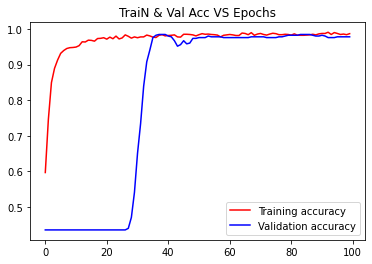

<Figure size 432x288 with 0 Axes>

In [17]:
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('TraiN & Val Acc VS Epochs')
plt.legend(loc=0)
plt.figure()
plt.show()

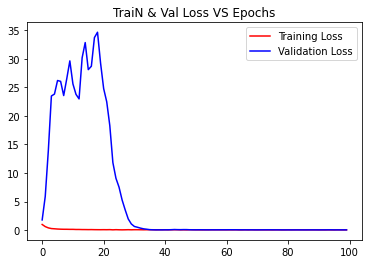

<Figure size 432x288 with 0 Axes>

In [18]:
epochs = range(len(acc))
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('TraiN & Val Loss VS Epochs')
plt.legend(loc=0)
plt.figure()
plt.show()

In [19]:
model.load_weights("ResNet50_Model.hdf5")
score = model.evaluate(X_val, Y_val ,verbose=1)
print('Test Loss:', score[0])
print('Test accuracy:', score[1]*100)

15/15 [==============================] - 1s 50ms/step - loss: 0.0362 - accuracy: 0.9846
Test Loss: 0.03621131181716919
Test accuracy: 98.46153855323792


Text(0.5, 1.0, 'Confusion Matrix')

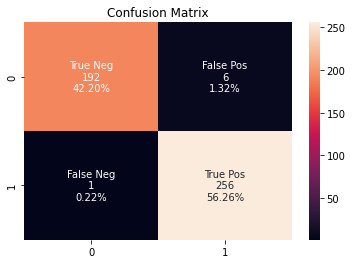

In [20]:
Y_pred = model.predict(X_val)
Y_predx = np.argmax(Y_pred, axis = -1)
Y_valx = np.argmax(Y_val, axis = -1)
cf_matrix = confusion_matrix(Y_valx, Y_predx)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot = labels, fmt = '')
plt.title("Confusion Matrix")